# L15d: Graph Classification with Graph Neural Networks (GNNs)
Fill me in.



### Tasks
Before we start, execute the `Run All Cells` command to check if you (or your neighbor) have any code or setup issues. Code issues, then raise your hands - and let's get those fixed!
* __Task 1: Setup, Data, Prerequisites (15 min)__: In this task, we set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and set up any constants required for stuff that comes later.
* __Task 2: Setup mini-batching., build a model and train the model (25 min)__: In this task, we'll setup a graphical neural netork model, wrangle the data into mini-batches, and train the model. We will use [the `GraphNeuralNetworks.jl` package](https://juliagraphs.org/GraphNeuralNetworks.jl/docs/GraphNeuralNetworks.jl/stable/) to create a graph neural network (GNN) model with a custom architure, and a custom training loop. Cool!
* __Task 3: Build and train a skip-gram model instance (20 min)__: In this task, we will build and train a skip-gram model instance on the sample input sequence we selected above. We start by creating a model instance, then train it for a few epochs and see how it performs.

Let's get started!
___

## Task 1: Setup, Data, Prerequisites
In this task, we set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and set up any constants required for stuff that comes later.
* The `Include.jl` file also loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Other packages are downloaded and then loaded.

In [1]:
include("Include.jl");

### Data
One common task for graph neural networks is the graph classification problem, e.g., a molecular property prediction task, in which _molecules are represented as graphs_, and the task may be to infer whether a molecule inhibits HIV virus replication or not. In this case, we'll look at a data for predicting the antimicrobial activity of small molecules.

The [TU Dortmund University](https://www.tu-dortmund.de/en/) has collected a wide range of different graph classification datasets, known as the [TUDatasets](https://chrsmrrs.github.io/datasets/), which are [accessible via the  `MLDatasets.jl` package](https://juliaml.github.io/MLDatasets.jl/stable/). Let's load and inspect one of the smaller ones, the __MUTAG dataset__:

In [2]:
dataset = TUDataset("MUTAG"); # download the dataset

_What's in the the dataset variable?_  The MUTAG dataset [from TU Dortmund University](https://www.tu-dortmund.de/en/) is a collection of 188 nitroaromatic compounds represented as graphs, labeled according to their mutagenic effect on the bacterium _Salmonella typhimurium_. It is widely used for benchmarking graph classification algorithms in cheminformatics and machine learning.

The [`GraphNeuralNetworks.jl` package](https://github.com/JuliaGraphs/GraphNeuralNetworks.jl.git) some useful utilities for working with graph datasets, *e.g.*, we load the graphs, randomly shuffle the dataset and use the first 150 graphs as training graphs, while using the remaining ones for testing, etc. Let's dig in a little deeper and see what is going on in the codee block below.

* The [`mldataset2gnngraph(...)` method](https://juliagraphs.org/GraphNeuralNetworks.jl/docs/GraphNeuralNetworks.jl/stable/GNNGraphs/api/datasets/#GNNGraphs.mldataset2gnngraph) converts a graph dataset from [the `MLDatasets.jl` package](https://juliaml.github.io/MLDatasets.jl/stable/) into one or many [`GNNGraph` instances](https://juliagraphs.org/GraphNeuralNetworks.jl/docs/GraphNeuralNetworks.jl/stable/GNNGraphs/api/gnngraph/#GNNGraphs.GNNGraph). Since the `MUTAG` dataset contains multiple graphs, we'll have an [array of `GNNGraph` instances](https://juliagraphs.org/GraphNeuralNetworks.jl/docs/GraphNeuralNetworks.jl/stable/GNNGraphs/api/gnngraph/#GNNGraphs.GNNGraph), where each instance contains the graph structure (nodes and edges) and any associated features or labels. The `graphs::Vector{GNNGraph}` array contains `188` graphs.
* Next, we (randomly) split the dataset into a training and test set. The training set contains `150` graphs, while the test set contains `38` graphs. We make use of [the `randperm(...)` method exported from the `Random.jl` package](https://docs.julialang.org/en/v1/base/random/#Random.randperm) to randomly permute the indices of the dataset. We then use the first `150` graphs as training graphs and the remaining `38` graphs as test graphs.

Now we convert the single-graph dataset to a `GNNGraph`. Moreover, we add a an array of node features, a **34-dimensional feature vector**  for each node which uniquely describes the members of the karate club. We also add a training mask selecting the nodes to be used for training in our semi-supervised node classification task.

In [3]:
raw_graphs_array = mldataset2gnngraph(dataset) # convert to GNNGraph instances, see documentation about this type.
graphs = [GNNGraph(g, ndata=Float32.(onehotbatch(g.ndata.targets, 0:6)), edata=nothing) for g ∈ raw_graphs_array]; # one hot encode the node labels

# build random training and test sets -
number_of_training_graphs = 150;
shuffled_indexes = randperm(length(graphs)) # shuffle the dataset using randperm
training_indexes = shuffled_indexes[1:number_of_training_graphs];
testing_indexes = shuffled_indexes[(number_of_training_graphs+1):end];
training_graphs = graphs[training_indexes]; # we'll use these graphs for training
testing_graphs = graphs[testing_indexes]; # we'll use these graphs for testing
ytrain = onehotbatch(dataset.graph_data.targets[training_indexes], [-1, 1])
ytest = onehotbatch(dataset.graph_data.targets[testing_indexes], [-1, 1]);

__What's in our test and training set?__  

By inspecting the first graph object of the dataset, we can see that it comes with **17 nodes** and **38 edges**. It also comes with exactly **one graph label**, and provides additional node labels (7 classes) and edge labels (4 classes). However, for the sake of simplicity, we did not make use of edge labels.

The output labels are [onehot batch encoded](https://fluxml.ai/Flux.jl/previews/PR1612/data/onehot/#Flux.onehotbatch) labels for both the training and test set. This gives [a OneHotMatrix](https://fluxml.ai/Flux.jl/previews/PR1612/data/onehot/) where kth column of the matrix is given by `onehot(ls[k], labels)`.

In [4]:
ytrain[:,2] # row 1: false, row 2: true

2-element OneHotVector(::UInt32) with eltype Bool:
 1
 ⋅

Let's visualize a graph in the training dataset. In the code block below we [use the `GraphMakie.jl` package](https://github.com/MakieOrg/GraphMakie.jl/tree/master) to draw the graph. The `GraphMakie.jl` package is a wrapper around the [`Makie.jl` package](https://github.com/MakieOrg/Makie.jl) which is a _super powerful_ visualization library.
* The [`graphplot(...)` method](https://graph.makie.org/stable/#GraphMakie.graphplot) is used to plot the graph. It takes the graph object as input and generates a visual representation of the graph, including nodes and edges. The inital (default) layout is not great, but you get the idea.

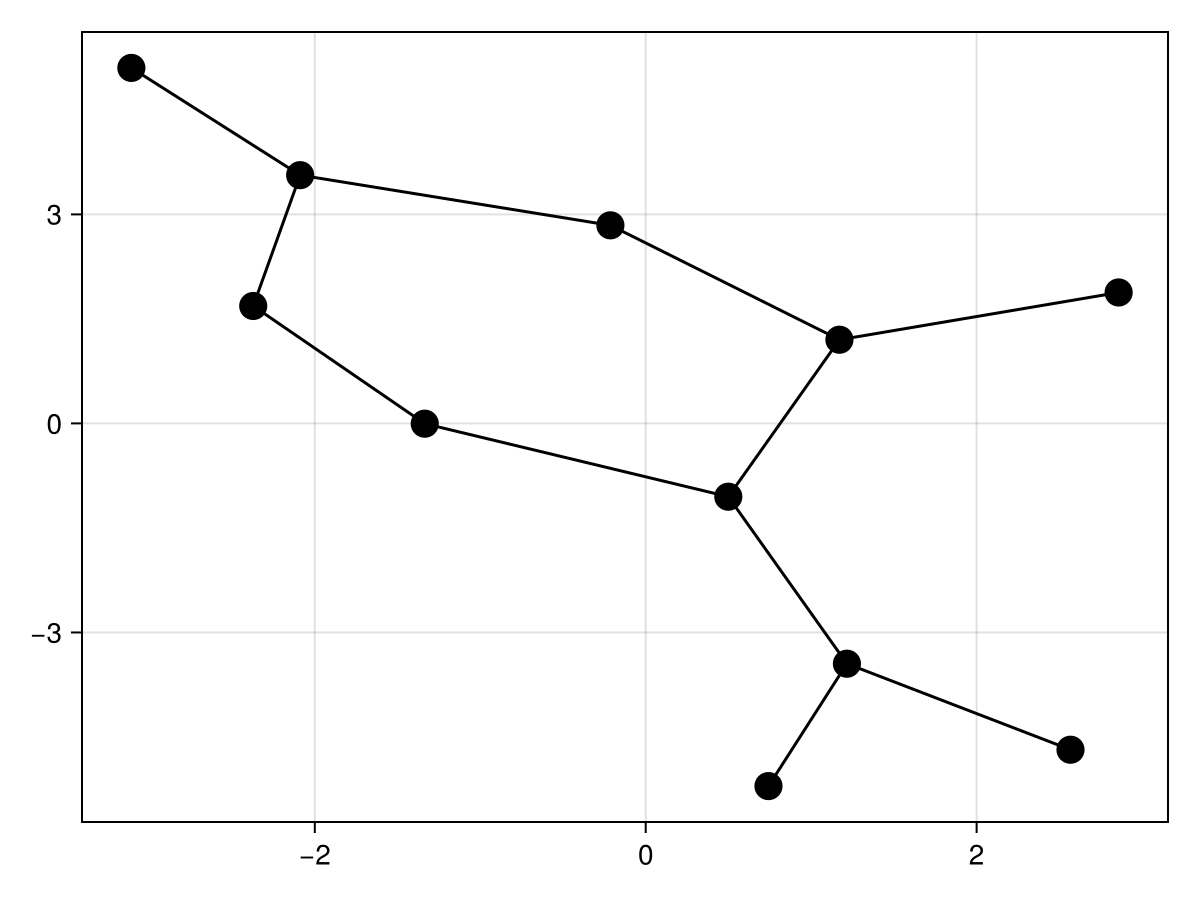

In [5]:
let
    index_of_graph_to_visualize = 10; # what graph to visualize?
    GraphMakie.graphplot(training_graphs[index_of_graph_to_visualize] |> to_unidirected, node_size = 20, arrow_show = false);
end

## Task 2: Setup mini-batching., build a model and train the model
In this task, we'll setup the model, wrangle the data into mini-batches, and train the model. We will use [the `GraphNeuralNetworks.jl` package](https://juliagraphs.org/GraphNeuralNetworks.jl/docs/GraphNeuralNetworks.jl/stable/) to create a graph neural network (GNN) model with a custom architure, and a custom training loop. Let's get started!


__Batching graphs__

Since graphs in graph classification datasets are usually small, a good idea is to **batch the graphs** before inputting them into any GNN training logic.

* _What is batching?_  Batching is a common technique used in machine learning to improve the efficiency of training and inference by processing multiple examples simultaneously. Mini-batching in graph neural networks involves grouping multiple graphs into small batches so that training and testing can be performed efficiently in parallel, improving computational performance. 
* _Common for neural networks?_ Yes, in the image or language domain, this procedure is typically achieved by **rescaling** or **padding** each example into a set of equally-sized shapes, and examples are then grouped in an additional dimension. The length of this dimension is then equal to the number of examples grouped in a mini-batch and is typically referred to as the `batchsize::Int`.
* _Is this great for GNNs?_ However, for GNNs the two approaches described above (rescaling or padding) are either not feasible or may result in a lot of unnecessary memory consumption. Therefore, [`GraphNeuralNetworks.jl`](https://github.com/JuliaGraphs/GraphNeuralNetworks.jl) opts for another approach to achieve parallelization across a number of examples. Here, adjacency matrices are stacked in a diagonal fashion (creating a giant graph that holds multiple isolated subgraphs), and node and target features are simply concatenated in the node dimension (the last dimension).

The [`GraphNeuralNetworks.jl` package](https://github.com/JuliaGraphs/GraphNeuralNetworks.jl) can **batch multiple graphs into a single giant graph** with the help of [the `DataLoader` type exported by the `MLUtils.jl` package](https://github.com/JuliaML/MLUtils.jl) that implicitly calls [the `Flux.batch(...)` method](https://fluxml.ai/Flux.jl/stable/reference/data/mlutils/#MLUtils.batch) on the data:

In [ ]:
batchsize_for_training = 64; # TODO: what happens if we change the batchsize for training?
batchsize_for_testing = 10; # batchsize for testing
train_loader = DataLoader((training_graphs, ytrain), batchsize=batchsize_for_training, shuffle=true, collate=true)
test_loader = DataLoader((testing_graphs, ytest), batchsize=batchsize_for_testing, shuffle=false, collate=true)

4-element DataLoader(::Tuple{Vector{GNNGraph{Tuple{Vector{Int64}, Vector{Int64}, Nothing}}}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=10, collate=Val{true}())
  with first element:
  (GNNGraph{Tuple{Vector{Int64}, Vector{Int64}, Nothing}}, 2×10 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

__What just happened?!?__: Let's dig into what is coming back to figure our what the batching operation is doing.

In [7]:
fieldnames(typeof(train_loader))

(:data, :_data, :batchsize, :buffer, :partial, :shuffle, :parallel, :collate, :rng)

In [8]:
train_loader.data[1]

150-element Vector{GNNGraph{Tuple{Vector{Int64}, Vector{Int64}, Nothing}}}:
 GNNGraph(21, 46) with x: 7×21 data
 GNNGraph(13, 28) with x: 7×13 data
 GNNGraph(19, 44) with x: 7×19 data
 GNNGraph(26, 60) with x: 7×26 data
 GNNGraph(13, 28) with x: 7×13 data
 GNNGraph(13, 28) with x: 7×13 data
 GNNGraph(15, 34) with x: 7×15 data
 GNNGraph(14, 28) with x: 7×14 data
 GNNGraph(11, 22) with x: 7×11 data
 GNNGraph(11, 22) with x: 7×11 data
 ⋮
 GNNGraph(16, 34) with x: 7×16 data
 GNNGraph(16, 34) with x: 7×16 data
 GNNGraph(23, 54) with x: 7×23 data
 GNNGraph(25, 56) with x: 7×25 data
 GNNGraph(12, 26) with x: 7×12 data
 GNNGraph(15, 32) with x: 7×15 data
 GNNGraph(17, 38) with x: 7×17 data
 GNNGraph(19, 44) with x: 7×19 data
 GNNGraph(22, 50) with x: 7×22 data

### Build and train our GNN model
Now that we have our data batched, we can build and train our GNN model. Let's start by setting some constants for the model, such as the number of input features, the number of hidden features, and the number of output classes, etc. See the comments next to the constants for more details on what they mean, permissble values, etc.

In [9]:
nin = 7 # dimension of the node feature vectors for each node
nout = 2 # output dimension for the system. Number of classes (in this case binary)
nh = 64 # number of hidden units

64

Next, lets define and train the GNN model. We will use a [custom `MyCustomConvolutionLayerModel` layer](src/Types.jl). You complete me.

In [10]:
mymodel = let
	
	Flux.@layer MyCustomConvolutionLayerModel

	inputlayer = MyCustomConvolutionLayerModel(nin => nh, relu);
	hiddenlayer = MyCustomConvolutionLayerModel(nh => nh, relu);
	outputlayer = MyCustomConvolutionLayerModel(nh => nh);

	model = GNNChain(inputlayer,
				hiddenlayer,
				outputlayer,
				GlobalPool(mean), # what is this doing?
				Dropout(0.5), # what is this doing?
				Dense(nh, nout))
				
	train!(model)
	model; # return the trained model
end;

# epoch = 0
train = (loss = 1.1985, acc = 68.67)
test = (loss = 1.6894, acc = 57.89)
# epoch = 10
train = (loss = 0.4924, acc = 76.0)
test = (loss = 0.5739, acc = 68.42)
# epoch = 20
train = (loss = 0.3953, acc = 80.67)
test = (loss = 0.4772, acc = 72.37)
# epoch = 30
train = (loss = 0.3475, acc = 80.67)
test = (loss = 0.5559, acc = 69.74)
# epoch = 40
train = (loss = 0.2955, acc = 86.67)
test = (loss = 0.4295, acc = 78.95)
# epoch = 50
train = (loss = 0.3221, acc = 82.33)
test = (loss = 0.4186, acc = 78.95)
# epoch = 60
train = (loss = 0.2717, acc = 87.67)
test = (loss = 0.3814, acc = 78.95)
# epoch = 70
train = (loss = 0.2475, acc = 87.67)
test = (loss = 0.3832, acc = 73.68)
# epoch = 80
train = (loss = 0.2206, acc = 89.67)
test = (loss = 0.3686, acc = 82.89)
# epoch = 90
train = (loss = 0.1967, acc = 89.33)
test = (loss = 0.2831, acc = 85.53)
# epoch = 100
train = (loss = 0.1939, acc = 88.67)
test = (loss = 0.3202, acc = 82.89)
# epoch = 110
train = (loss = 0.2069, acc = 89.33)
test